In [1]:
# Time lapse analysis tool:
#Requires:
#1. Metadata excel file containing info about each tracking file and Ventricular zone coordinates and cortex thickness
#2. Ventricular zone line x,y coordinates

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib 
from scipy.interpolate import interp1d
#Hide all warnings
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import multiprocessing
from joblib import Parallel, delayed
from timeit import default_timer as timer
import seaborn as sns
from scipy.spatial import distance

In [181]:
def Timelapse ():
    metadata = pd.read_excel(os.getcwd() + '/Input/Metadata.xlsx') #Open Metadatafile
    wd = os.getcwd()
    
    #Concatenate all tracks into one df
    out = pd.DataFrame()
    for i in range(len(metadata)):
        #Open File with Ventricular Zone line x,y coordinates
        vz = round(pd.read_csv(wd + '/Input/' + str(metadata.Ventricular_Zone_Line_Filename[i]),names=['x','y'], sep=' ', usecols=[1,2]))

        #Open tracking file and calculate minimum distance of each cell at each timepoint to vz
        temp = pd.read_csv(wd + '/Input/' + str(metadata.Filename[i]))
        Filter1 = ['X','Y']
        cell_xy = temp[Filter1]
        temp['vz_distance'] = distance.cdist(cell_xy, vz, 'euclidean').min(axis=1) #distance
        temp['relative_distance'] = temp.vz_distance/metadata.CP_thickness_px[i]
        
        #Add columns from Metadata
        temp['Experiment'] = metadata.Experiment[i]
        temp['Position'] = metadata.Position[i]
        temp['Condition'] = metadata.Condition[i]
        
        # Merge Track n column with Experiment column to have unique identifier for each track
        temp['ID'] = str(metadata.Experiment[i]) +' '+ temp['Track n°'].map(str) + ' ' +str(metadata.Position[i]) + ' '+str(metadata.Condition[i])
        
        #Insert timestamp in Minutes for each track
        temp = temp.reset_index()
        temp['time[min]'] = temp['Slice n°']*metadata['Intervall_in_min'][i]
        
        #Split apply combine to normalize timestamp to 0 for each track
        grouped=temp.groupby('Track n°')
        #Determine minimum distance of each track of each timepoint to the vz
        temp['time[min]_rel'] = grouped['time[min]'].apply(lambda x: (x-x.min()))
        
        # Filter unwanted columns
        Filter = ['ID','Condition','relative_distance','time[min]_rel']
        temp = temp[Filter]
        
        #Append to one big dataframe
        out = out.append(temp, ignore_index=True)
    
    #Save to excel file in the Output folder
    out.to_excel(wd + '/Output/AlldataDistance.xlsx')
    
    # Plotting
    plt.figure(figsize=(5,5))
    ax=sns.lineplot(x='time[min]_rel', y='relative_distance', data=out, hue='Condition', ci='sd', palette=(['red','grey','orange']), legend=False)
    #ax.set(xlabel='Time [min]', ylabel='Normalized Position in Cortex')
    ax.set(ylim=(0,1.1))
    ax.set(xlim=(0,2800))
    ax.axhline(0.5, ls='--', color ='grey')
    ax.axhline(1, ls='--', color='grey')
    ax.set_xlabel('Time [min]', fontsize=20)
    ax.set_ylabel('Normalized Position in Cortex', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.xaxis.set_major_locator(plt.MultipleLocator(700))
    plt.savefig(os.getcwd() + '/Output/'  + ' Neuronal_Migration'+ '.png',dpi=300,bbox_inches='tight') 
    
    plt.figure(figsize=(5,5))
    ax=sns.lineplot(x='time[min]_rel', y='relative_distance', data=out, hue='Condition', ci='sd', palette=(['red','grey','orange']))
    ax.set(ylim=(0,1.1))
    ax.set(xlim=(0,2800))
    ax.axhline(0.5, ls='--', color ='grey')
    ax.axhline(1, ls='--', color='grey')
    ax.set_xlabel('Time [min]', fontsize=20)
    ax.set_ylabel('Normalized Position in Cortex', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.xaxis.set_major_locator(plt.MultipleLocator(700))
    plt.savefig(os.getcwd() + '/Output/'  + ' Neuronal_Migration_legend'+ '.png',dpi=300,bbox_inches='tight')   
    
    plt.figure(figsize=(5,5))
    ax=sns.lineplot(x='time[min]_rel', y='relative_distance', data=out, hue='Condition', palette=(['red','grey','orange']), legend=False)
    ax.set(ylim=(0,1.1))
    ax.set(xlim=(0,2800))
    ax.axhline(0.5, ls='--', color ='grey')
    ax.axhline(1, ls='--', color='grey')
    ax.set_xlabel('Time [min]', fontsize=20)
    ax.set_ylabel('Normalized Position in Cortex', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.xaxis.set_major_locator(plt.MultipleLocator(700))
    plt.savefig(os.getcwd() + '/Output/'  + ' Neuronal_Migration_ci95'+ '.png',dpi=300,bbox_inches='tight') 
    
    plt.figure(figsize=(5,5))
    ax=sns.lineplot(x='time[min]_rel', y='relative_distance', data=out, hue='Condition', palette=(['red','grey','orange']))
    ax.set(ylim=(0,1.1))
    ax.set(xlim=(0,2800))
    ax.axhline(0.5, ls='--', color ='grey')
    ax.axhline(1, ls='--', color='grey')
    ax.set_xlabel('Time [min]', fontsize=20)
    ax.set_ylabel('Normalized Position in Cortex', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.xaxis.set_major_locator(plt.MultipleLocator(700))
    plt.savefig(os.getcwd() + '/Output/'  + ' Neuronal_Migration_legend_ci95'+ '.png',dpi=300,bbox_inches='tight')   

       relative_distance  time[min]_rel
count       13925.000000   13925.000000
mean            0.595727    1099.883662
std             0.205999     735.926593
min             0.093757       0.000000
25%             0.425782     500.000000
50%             0.565813    1000.000000
75%             0.776718    1600.000000
max             1.106796    3300.000000


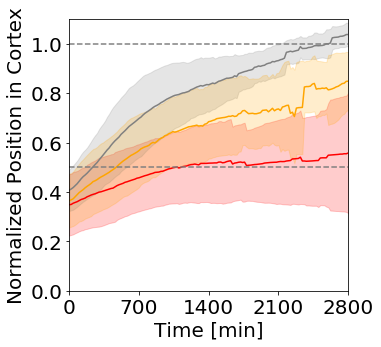

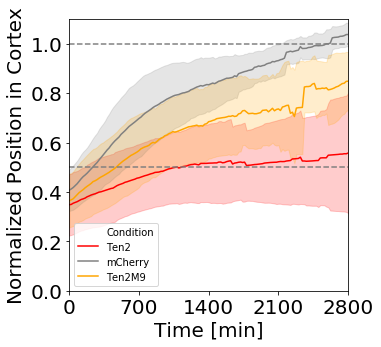

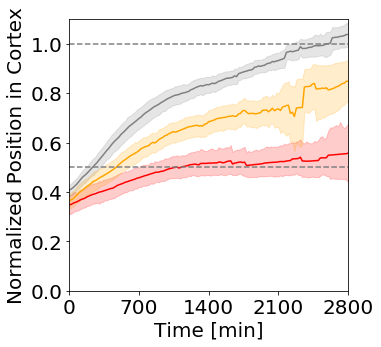

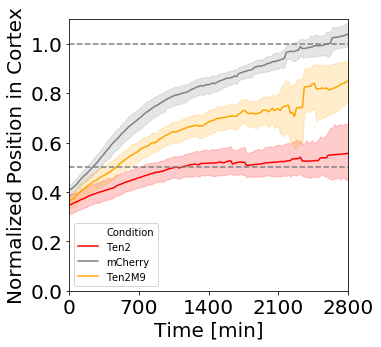

In [180]:
Timelapse()

In [195]:
def Timelapse_Speed (threshold, orient, xlimit, xlabel):
    metadata = pd.read_excel(os.getcwd() + '/Input/Metadata.xlsx') #Open Metadatafile
    wd = os.getcwd()
    
    #Concatenate all tracks into one df
    out = pd.DataFrame()
    for i in range(len(metadata)):
        #Open tracking file and calculate minimum distance of each cell at each timepoint to vz
        temp = pd.read_csv(wd + '/Input/' + str(metadata.Filename[i]))
        
        #Add columns from Metadata
        temp['Experiment'] = metadata.Experiment[i]
        temp['Position'] = metadata.Position[i]
        temp['Condition'] = metadata.Condition[i]
        
        # Merge Track n column with Experiment column to have unique identifier for each track
        temp['ID'] = str(metadata.Experiment[i]) +' '+ temp['Track n°'].map(str) + ' ' +str(metadata.Position[i]) + ' '+str(metadata.Condition[i])
        
        #Insert timestamp in Minutes for each track
        temp = temp.reset_index()
        temp['time[min]'] = temp['Slice n°']*metadata['Intervall_in_min'][i]
        
        #Calculate speed
        #Calculate Distance travelled
        temp['dX'] = abs(temp.X.diff())
        temp['dY'] = abs(temp.Y.diff())
        #Calculate speed
        temp['Speed_um_h'] = (np.sqrt(np.power(temp['dX'],2) + np.power(temp['dY'],2))*metadata['Scale_umperpx'][i])/(metadata['Intervall_in_min'][i]/60)
        # Filter unwanted columns
        Filter = ['ID','Condition','Speed_um_h']
        temp = temp[Filter]
        
        #Append to one big dataframe
        out = out.append(temp, ignore_index=True)
        
    #Remove all speeds below threshold
    out = out[out['Speed_um_h']>threshold]
    #Calculate mean per tracked neuron
    out = out.groupby(['ID','Condition']).mean()
    out.reset_index(inplace=True)
    
    #Save to excel file in the Output folder
    out.to_excel(wd + '/Output/Neuronal_Migration_Speed'+ orient + '_threshold_'+ str(threshold) + 'µm_h' + '.xlsx')
    
    # Plotting
    plt.figure(figsize=(5,1.5))
    ax=sns.boxplot(y='Condition', x='Speed_um_h',data=out, palette=(['grey','orange','red']),orient='h',linewidth=0.75,
                  order=['mCherry','Ten2M9','Ten2'])
    ax.set(xlim=(0,xlimit))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel('', fontsize=20)
    ax.tick_params(labelsize=20)
    plt.savefig(os.getcwd() + '/Output/'  + ' Neuronal_Migration_Speed_'+ orient + '_threshold_'+ str(threshold) + 'µm_h' +'.png',
                dpi=300,bbox_inches='tight') 

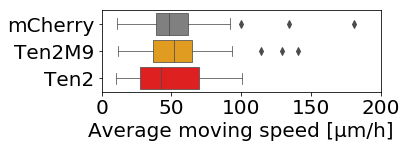

In [196]:
Timelapse_Speed(10,'h',200, 'Average moving speed [µm/h]')

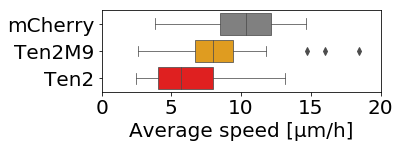

In [197]:
Timelapse_Speed(0,'h',20, 'Average speed [µm/h]')